# Исследование надежности заемщиков

## Ⅰ. Загрузка данных

In [86]:
# Загрузка необходимых модулей

# !pip install imbalanced-learn
# !pip install ydata-profiling

In [87]:
# импортируем библиотeки

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (f1_score,
                             confusion_matrix,
                             mean_squared_error,
                             mean_absolute_error,
                             classification_report,
                             roc_auc_score,
                             roc_curve,
                             precision_score,
                             recall_score)
from imblearn.over_sampling import RandomOverSampler

In [88]:
# загружаем данные

try:
    data = pd.read_csv('/datasets/data.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

In [89]:
data.head()

children  days_employed  dob_years education  education_id  \
0         1   -8437.673028         42    высшее             0   
1         1   -4024.803754         36   среднее             1   
2         0   -5623.422610         33   Среднее             1   
3         3   -4124.747207         32   среднее             1   
4         0  340266.072047         53   среднее             1   

      family_status  family_status_id gender income_type  debt   total_income  \
0   женат / замужем                 0      F   сотрудник     0  253875.639453   
1   женат / замужем                 0      F   сотрудник     0  112080.014102   
2   женат / замужем                 0      M   сотрудник     0  145885.952297   
3   женат / замужем                 0      M   сотрудник     0  267628.550329   
4  гражданский брак                 1      F   пенсионер     0  158616.077870   

                      purpose  
0               покупка жилья  
1     приобретение автомобиля  
2               покупка жилья  
3  дополнительное образование  
4             сыграть свадьбу

In [90]:
# выведем основную информацию о датафрейме

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Для дальнейшей работы необходимо произвести следующие манипуляции с данными:
- проверить данные на явные и неявные дубликаты
- избавиться от пропущенных значений
- преобразовать тип у некоторых данных
- проверить на уникальность значений категориальных переменных
- избавиться от выбросов

## Ⅱ. Исследовательский анализ данных

### Удаление дубликатов

In [91]:
dupl = data.duplicated().sum()
print(f'Обнаружено пропусков: {dupl}')

Обнаружено пропусков: 54


In [92]:
# удаление дубликатов

data = data.drop_duplicates().reset_index(drop=True)
dupl = data.duplicated().sum()
print(f'Обнаружено пропусков: {dupl}')

Обнаружено пропусков: 0


### Удаление пропусков

In [93]:
# пропущенные значения для каждого признака

data.isna().sum()

children               0
days_employed       2120
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2120
purpose                0
dtype: int64

In [94]:
# удалим пропуски

data = data.dropna().reset_index(drop = True)
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Измненение типов данных

In [95]:
# преобразуем 'total_income' и 'days_employed' в целочисленный тип

data['total_income'] = data['total_income'].astype('int64')
data['days_employed'] = data['days_employed'].astype('int64')

# Заменим отрицательные значения в 'days_employed' на положительные

data['days_employed'] = abs(data['days_employed']);

In [96]:
# преобразуем 'debt' в булевый тип

data['debt'] = data['debt'].astype('bool')

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19351 entries, 0 to 19350
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          19351 non-null  int64 
 1   days_employed     19351 non-null  int64 
 2   dob_years         19351 non-null  int64 
 3   education         19351 non-null  object
 4   education_id      19351 non-null  int64 
 5   family_status     19351 non-null  object
 6   family_status_id  19351 non-null  int64 
 7   gender            19351 non-null  object
 8   income_type       19351 non-null  object
 9   debt              19351 non-null  bool  
 10  total_income      19351 non-null  int64 
 11  purpose           19351 non-null  object
dtypes: bool(1), int64(6), object(5)
memory usage: 1.6+ MB


### Обнаружение аномалий

In [98]:
# уникальные значения в категории education

data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

In [99]:
# преобразуем неявные дубликаты к единой форме

def change_duplicates(word):
    for word in data['education'].unique():
        if word in ['Начальное', 'НАЧАЛЬНОЕ']:
            data.loc[data['education']==word, 'education'] = 'начальное'
        if word in ['Среднее', 'СРЕДНЕЕ']:
            data.loc[data['education']==word, 'education'] = 'среднее'
        if word in ['Высшее', 'ВЫСШЕЕ']:
            data.loc[data['education']==word, 'education'] = 'высшее'
        if word in ['Неоконченное высшее', 'НЕОКОНЧЕННОЕ ВЫСШЕЕ']:
            data.loc[data['education']==word, 'education'] = 'неоконченное высшее'
        if word in ['Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ']:
            data.loc[data['education']==word, 'education'] = 'ученая степень'

data['education'].apply(change_duplicates);

In [100]:
data['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

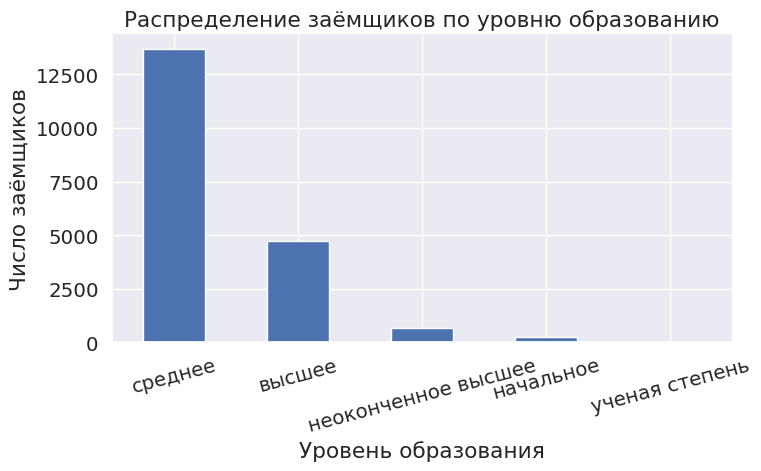

In [101]:
# график распределения заёмщиков по уровню образования

data['education'].value_counts().plot(kind='bar', figsize=(8, 4), title='Распределение заёмщиков по уровню образованию')
plt.xticks(rotation=15)
plt.ylabel('Число заёмщиков')
plt.xlabel('Уровень образования')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show();

In [102]:
# уникальные значения в категории family_status

data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

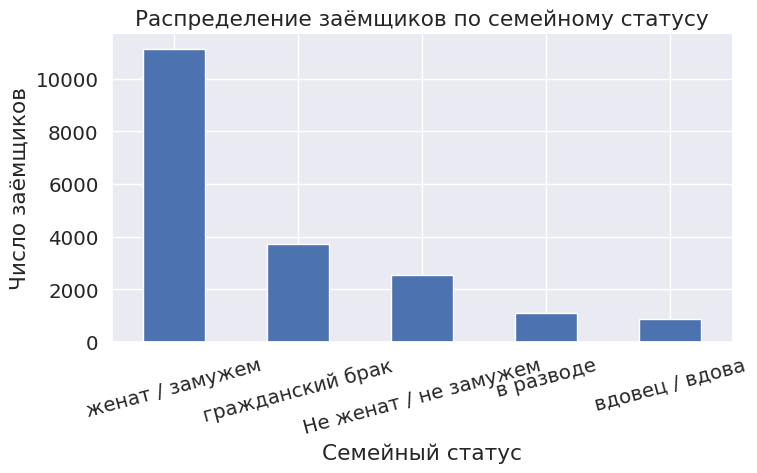

In [103]:
# график распределения заёмщиков по семейному статусу

data['family_status'].value_counts().plot(kind='bar', figsize=(8, 4), title='Распределение заёмщиков по семейному статусу')
plt.xticks(rotation=15)
plt.ylabel('Число заёмщиков')
plt.xlabel('Семейный статус')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show();

In [104]:
# уникальные значения в категории gender

data['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

In [105]:
data.groupby('gender')['gender'].count()

gender
F      12752
M       6598
XNA        1
Name: gender, dtype: int64

In [106]:
# удалим единственную строку с неопределённым полом заёмщика

data = data.loc[data['gender'] != 'XNA']
data = data.reset_index(drop=True)
data['gender'].unique()

array(['F', 'M'], dtype=object)

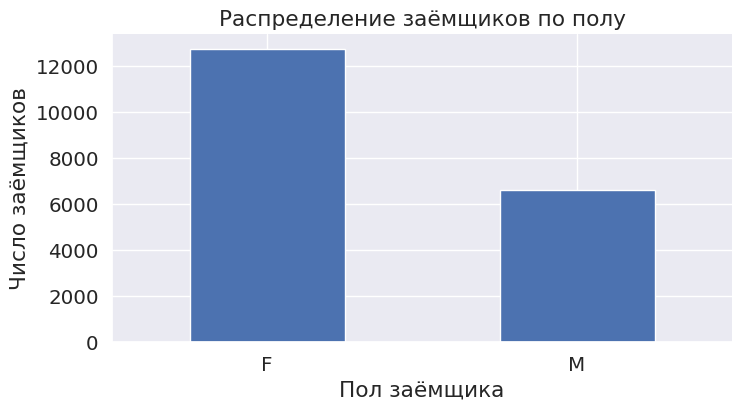

In [107]:
# график распределения заёмщиков по полу

data['gender'].value_counts().plot(kind='bar', figsize=(8, 4), title='Распределение заёмщиков по полу')
plt.xticks(rotation=0)
plt.ylabel('Число заёмщиков')
plt.xlabel('Пол заёмщика')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show();

In [108]:
# уникальные значения в категории income_type

data['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'студент', 'предприниматель', 'в декрете'],
      dtype=object)

In [109]:
# число заёмщиков каждой категории в income_type

data['income_type'].value_counts().to_frame()

count
income_type           
сотрудник        10014
компаньон         4576
пенсионер         3443
госслужащий       1312
безработный          2
студент              1
предприниматель      1
в декрете            1

Несколько категорий, которые имеют небольшое количество объектов не представляют ценности для исследования: безработный, предприниматель, студент, в декрете.

In [110]:
# удалим несущественные признаки

drop_obj_list = ['безработный', 'предприниматель', 'студент', 'в декрете']

data = data[~data['income_type'].isin(drop_obj_list)]
data = data.reset_index(drop = True)
data.shape

(19345, 12)

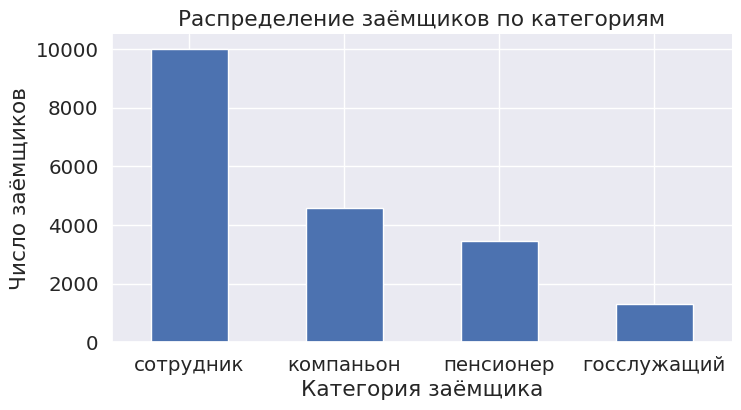

In [111]:
# график распределения заёмщиков по категории

data['income_type'].value_counts().plot(kind='bar', figsize=(8, 4), title='Распределение заёмщиков по категориям')
plt.xticks(rotation=0)
plt.ylabel('Число заёмщиков')
plt.xlabel('Категория заёмщика')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show();

In [112]:
# уникальные значения в категории purpose

data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'получение образования',
       'сделка с подержанным автомобилем', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее образование',
       'покупка жилья для сдачи

Произведём категоризацию данных из столбца `purpose` и сформируем новый столбец `purpose_category`, с основными категориями:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

In [113]:
# категоризация по purpose

def categorize_purpose(deal):
    if deal.find('автомобил')>=0:
        return 'операции с автомобилем'
    elif deal.find('жиль')>=0:
        return 'операции с недвижимостью'
    elif deal.find('недвижимост')>=0:
        return 'операции с недвижимостью'
    elif deal.find('свадьб')>=0:
        return 'проведение свадьбы'
    elif deal.find('образовани')>=0:
        return 'получение образования'

data['purpose_category'] = data['purpose'].apply(categorize_purpose)

In [114]:
# удалим признак purpose и переименуем purpose_category в purpose

data = data.drop('purpose', axis = 1)
data.rename(columns = {'purpose_category': 'purpose'}, inplace = True)

In [115]:
data.sample(3)

children  days_employed  dob_years education  education_id  \
1501         0           5056         48    высшее             0   
5237         0           5022         44   среднее             1   
8149         0           6647         63    высшее             0   

        family_status  family_status_id gender  income_type   debt  \
1501  женат / замужем                 0      F    сотрудник  False   
5237        в разводе                 3      M  госслужащий  False   
8149  женат / замужем                 0      M    сотрудник  False   

      total_income                   purpose  
1501        168667  операции с недвижимостью  
5237        367921  операции с недвижимостью  
8149        253680     получение образования

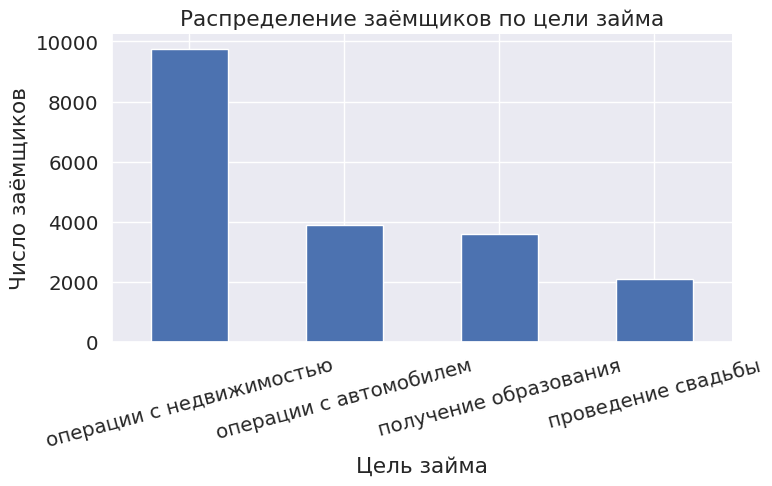

In [116]:
# график распределения заёмщиков по цели займа

data['purpose'].value_counts().plot(kind='bar', figsize=(8, 4), title='Распределение заёмщиков по цели займа')
plt.xticks(rotation=15)
plt.ylabel('Число заёмщиков')
plt.xlabel('Цель займа')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show();

In [117]:
# уникальные значения 'children'

data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

В столбце children есть два аномальных значения. Удалим строки, в которых встречаются такие аномальные значения из датафрейма data.

In [118]:
data = data[(data['children'] != -1) & (data['children'] != 20)].reset_index(drop = True)
data['children'].unique()

array([1, 0, 3, 2, 4, 5])

In [119]:
data['children'].value_counts()

children
0    12706
1     4342
2     1850
3      294
4       34
5        8
Name: count, dtype: int64

In [120]:
# исключим заёмщиков с количеством детей больше трёх как несущественных

data = data[data['children'] < 4].reset_index(drop = True)

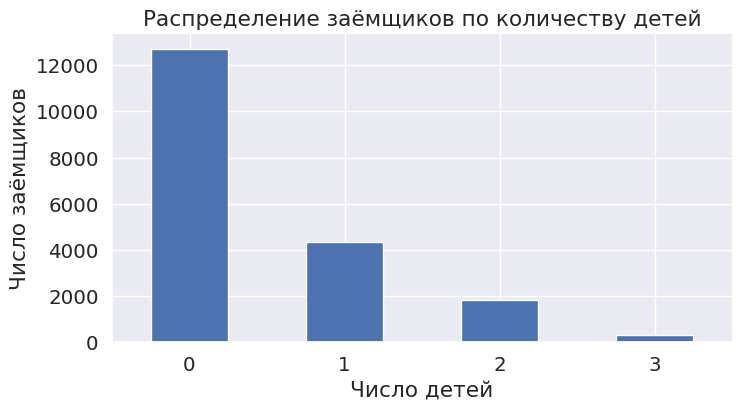

In [121]:
# график распределения заёмщиков по количеству детей

data['children'].value_counts().plot(kind='bar', figsize=(8, 4), title='Распределение заёмщиков по количеству детей')
plt.xticks(rotation=0)
plt.ylabel('Число заёмщиков')
plt.xlabel('Число детей')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show();

In [122]:
# количество заёмщиков, у которых возраст по данным равен 0

age_zero = data[data['dob_years'] == 0].shape[0]
print(f'Заёмщиков с 0-ым возрастом в признаке: {age_zero}')

Заёмщиков с 0-ым возрастом в признаке: 90


In [123]:
# заменим нулевые значения возраста на медиану возраста в соответствии с типом занятости заёмщика

for job in data['income_type'].unique():
    job_median = data.loc[data['income_type']==job]['dob_years'].median()
    data.loc[(data['income_type']==job) & (data['dob_years'] == 0),'dob_years'] = job_median;


data['dob_years'] = data['dob_years'].astype('int64');


In [124]:
age_zero = data[data['dob_years'] == 0].shape[0]
print(f'Заёмщиков с 0-ым возрастом в признаке: {age_zero}')

Заёмщиков с 0-ым возрастом в признаке: 0


In [125]:
data['dob_years'].describe()

count    19192.000000
mean        43.486453
std         12.245905
min         19.000000
25%         33.000000
50%         43.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64

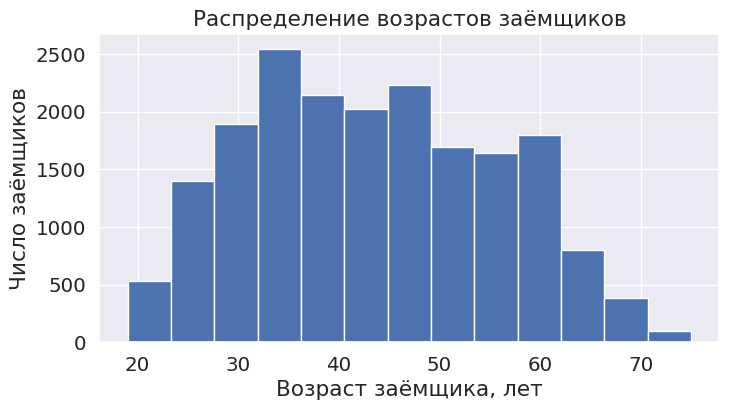

In [126]:
plt.figure(figsize=(8, 4))
plt.hist(data['dob_years'], histtype = 'bar', bins = 13)
plt.ylabel('Число заёмщиков')
plt.xlabel('Возраст заёмщика, лет')
plt.title("Распределение возрастов заёмщиков")
plt.show();

На основании диапазонов, указанных ниже, создадим в датафрейме столбец `total_income_category` с категориями:

- 1000001 и выше — `'A'`;
- 200001–1000000 — `'B'`;
- 50001–200000 — `'C'`;
- 30001–50000 — `'D'`;
- 0–30000 — `'E'`.

In [127]:
# создадим функцию categorize_income()

def categorize_income(income):
    if income > 1000000:
        return 'A'
    elif income > 200000:
        return 'B'
    elif income > 50000:
        return 'C'
    elif income > 30000:
        return 'D'
    else:
        return 'E'

In [128]:
data['total_income_category'] = data['total_income'].apply(categorize_income)
data.sample(3);

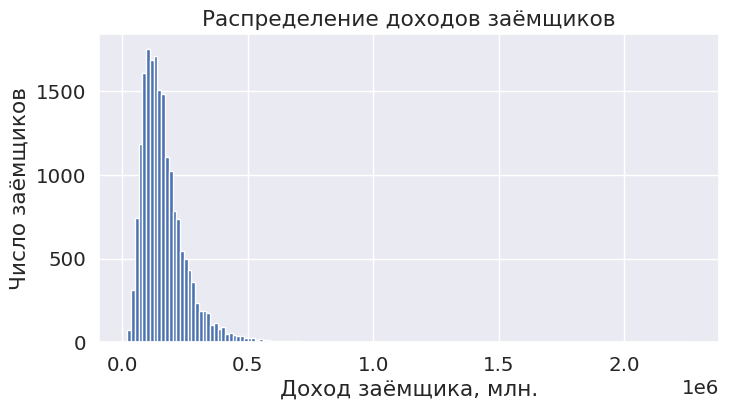

In [129]:
plt.figure(figsize=(8, 4))
plt.hist(data['total_income'], bins = 150)
plt.ylabel('Число заёмщиков')
plt.xlabel('Доход заёмщика, млн.')
plt.title("Распределение доходов заёмщиков")
plt.show();

In [130]:
# имел ли заёмщик проблемы с возвратом кредита

data['debt'].value_counts()

debt
False    17635
True      1557
Name: count, dtype: int64

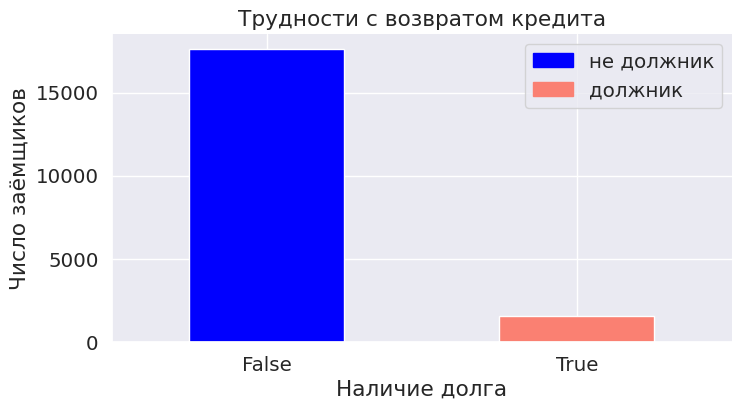

In [131]:
# график распределения заёмщиков c долгами

colors = ['blue', 'salmon']

data['debt'].value_counts().plot(kind='bar', figsize=(8, 4), color=colors, title='Трудности с возвратом кредита')
plt.xticks(rotation=0)
plt.ylabel('Число заёмщиков')
plt.xlabel('Наличие долга')
plt.gca().spines[['top', 'right']].set_visible(False)

handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
labels = ['не должник', 'должник']
plt.legend(handles, labels)

plt.show();

In [132]:
not_returned = data['debt'].value_counts().reset_index().iloc[1,1]

print(f'Доля заёмщиков, у которых были проблемы с возвратом кредита: {round(not_returned/data.shape[0], 2)}')

Доля заёмщиков, у которых были проблемы с возвратом кредита: 0.08


### Удаление выбросов

In [133]:
data.describe()

children  days_employed     dob_years  education_id  \
count  19192.000000   19192.000000  19192.000000  19192.000000   
mean       0.464985   67131.138495     43.486453      0.818831   
std        0.730413  139214.561512     12.245905      0.550748   
min        0.000000      24.000000     19.000000      0.000000   
25%        0.000000     927.000000     33.000000      1.000000   
50%        0.000000    2197.000000     43.000000      1.000000   
75%        1.000000    5564.250000     53.000000      1.000000   
max        3.000000  401755.000000     75.000000      4.000000   

       family_status_id  total_income  
count      19192.000000  1.919200e+04  
mean           0.974625  1.674356e+05  
std            1.422015  1.031285e+05  
min            0.000000  2.066700e+04  
25%            0.000000  1.029902e+05  
50%            0.000000  1.449750e+05  
75%            1.000000  2.034298e+05  
max            4.000000  2.265604e+06

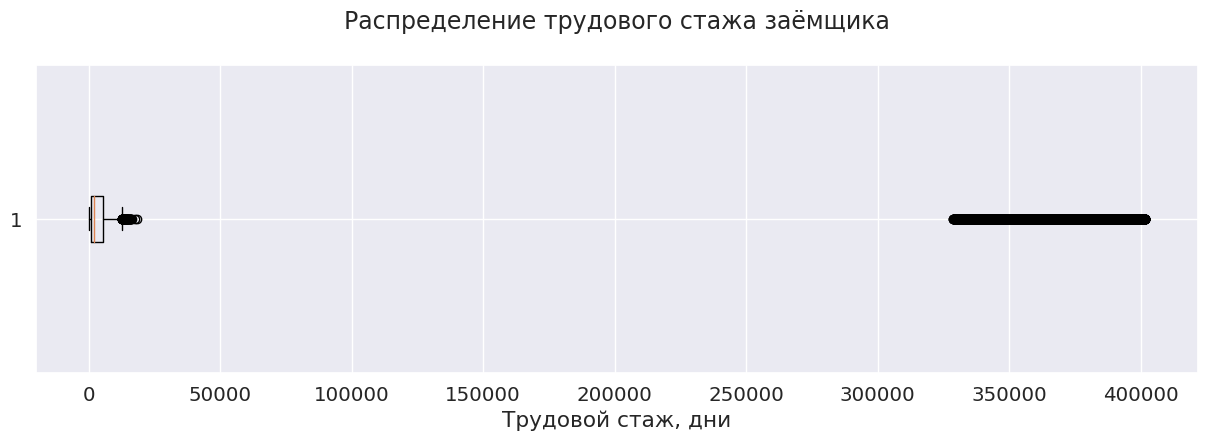

In [134]:
# boxplot распределения трудового стажа

plt.figure(figsize=(15, 4))
plt.boxplot(data['days_employed'], vert=False)
plt.title('Распределение трудового стажа заёмщика' + "\n", fontsize=17);
plt.xlabel('Трудовой стаж, дни')
plt.show();

In [135]:
# удалим аномальные значения для "days_employed"

Q1 = data['days_employed'].quantile(0.25)
Q3 = data['days_employed'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
data = data[data['days_employed'] < upper_bound]
data.shape

(15696, 13)

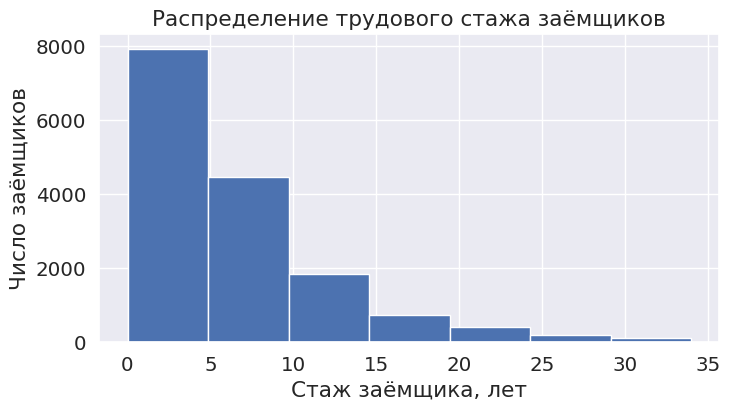

In [136]:
df_years_employed = round(data['days_employed']/365).astype('int')

plt.figure(figsize=(8, 4))
plt.hist(df_years_employed, bins = 7)
plt.ylabel('Число заёмщиков')
plt.xlabel('Стаж заёмщика, лет')
plt.title("Распределение трудового стажа заёмщиков")
plt.show();

### Профайлинг

In [137]:
from ydata_profiling import ProfileReport
df_profile = data.drop(columns = ['education_id', 'family_status_id', 'total_income_category'])
profile = ProfileReport(df_profile)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Вывод**

В разделе "Исследовательский анализ данных" была произведена следующая работа с данными:
1. Обнаружены и удалены явные и неявные дубликаты
2. Удалены пропуски
3. Изменены типы некоторых признаков
4. Удалены выбросы
5. Сделана категоризация некоторых признаков

`Образование заёмщика`  
Анализ показал, что люди со средним образованием чаще берут кредиты, на втором месте - с высшим образованием. Клиенты с неоконченным высшим, начальным образованием, а также с учёной степенью реже берут кредит.

`Семейный статус`  
Находящиеся в браке чаще берут займ. На втором месте неженатые и находящиеся в гражданском браке. Реже берут кредиты те, кто в разводе или одинокие.

`Пол заёмщика`   
Женщины чаще берут кредиты.

`Тип занятости`  
Сотрудники и компаньоны чаще обращаются за кредитом, чем пенсионеры. Госслужащие реже всех обращаются в банки.

`Цель займа`  
Самая популярная цель займа - операции с недвижимостью. На втором и третьем местах - операции с автомобилями и получение образования, на последнем месте - проведение свадьбы.

`Количество детей`  
За кредитом чаще обращаются клиенты не имеющие детей. На втором, третьем и четвёртом местах по количеству обращений находятся клиенты имеющие по одному, два и три ребёнка соответственно.

`Возраст заёмщика`  
Средний возраст заёмщика - 39 лет.

`Долги`  
8% заёмщиков имели проблемы с возвратом кредита.

`Доход заёмщика`  
Кредиты чаще берут граждане с доходом от 50 000 до 200 000 тыс, что является средними доходами. На втором месте люди с доходом выше среднего.

`Трудовой стаж`  
С увеличением трудового стажа заёмщик реже обращается за кредитом. Клиенты с трудовым стажем до 10 лет чаще берут кредиты.

## Ⅲ. Вопросы исследования

- есть ли зависимость между количеством детей и возвратом кредита в срок?
- есть ли зависимость между семейным положением и возвратом кредита в срок?
- есть ли зависимость между уровнем дохода и возвратом кредита в срок?
- как разные цели кредита влияют на его возврат в срок?

#### Есть ли зависимость между количеством детей и кредитоспособностью заёмщика?

Чтобы найти зависимость между количеством детей у заёмщика и его способностью возвратить долг вовремя необходимо найти среднее количество невозвращённого долга на каждую семью с учётом группировки по количеству имеющихся детей. Далее, на основании этих данных построим сводную таблицу.

In [138]:
table1 = (data.groupby('children')['debt']
             .agg(['sum','count','mean'])
             .rename(columns={'sum': 'debt', 'count': 'debt_count', 'mean': 'debt_ratio'})
             .sort_values('debt_ratio'))

table1['debt_ratio'] = round(table1['debt_ratio']*100, 2)
table1 = table1.sort_values('debt_count', ascending=False)
table1

debt  debt_count  debt_ratio
children                              
0          785        9491        8.27
1          396        4085        9.69
2          174        1832        9.50
3           21         288        7.29

Колонка `children` показывает количество детей у заёмщика,  
`debt` - количество заёмщиков невозвративших кредит в срок,  
`debt_count` - количество заёмщиков в каждой группе по кол-ву детей,  
`debt_ratio` - отношение `debt` к `debt_count`.  

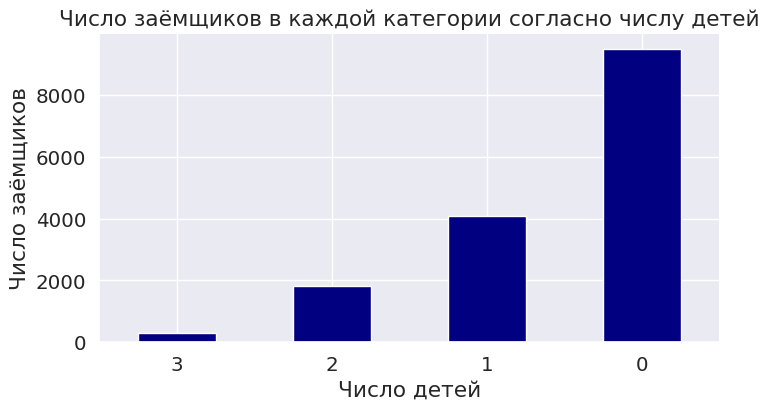

In [139]:
# посмотрим на число заёмщкиков с разным количеством детей

table1.sort_values('debt_count', ascending = True)['debt_count'].plot(kind='bar',
                                                                      figsize=(8, 4),
                                                                      title = 'Число заёмщиков в каждой категории согласно числу детей',
                                                                      color = 'navy')
plt.xticks(rotation=0)
plt.ylabel('Число заёмщиков')
plt.xlabel('Число детей')
plt.gca().spines[['top', 'right']].set_visible(False);

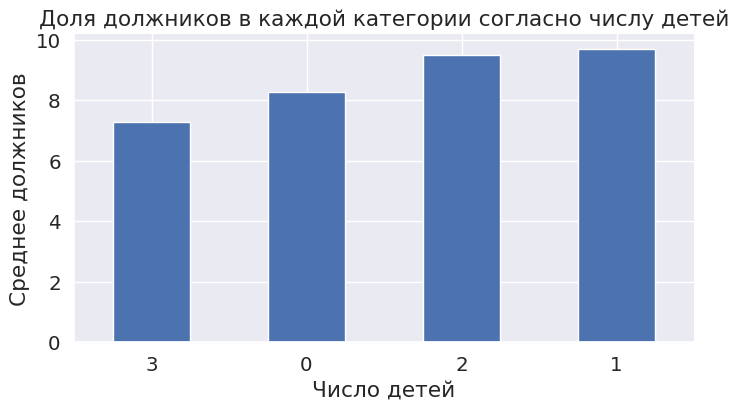

In [140]:
# доля должников к числу заёмщиков в разрезе количества детей

table1.sort_values('debt_ratio', ascending = True)['debt_ratio'].plot(kind='bar',
                                                                      figsize=(8, 4),
                                                                      title='Доля должников в каждой категории согласно числу детей')
plt.xticks(rotation=0)
plt.ylabel('Среднее должников')
plt.xlabel('Число детей')
plt.gca().spines[['top', 'right']].set_visible(False);

>**Вывод:**  
>У заёмщиков, имеющих трое детей самый низкий показатель уровеня задолженности. На втором месте - заёмщики без детей. Самый высокий показатель невозвратов у заёмщика с одним ребёнком. С другой стороны бездетные представляют самую многочисленную группу заёмщиков, заёмщики с тремя детьми самую малочисленную.

#### Есть ли зависимость между семейным положением и кредитоспособностью заёмщика?

Найдём отношение невозвративших вовремя кредит заёмщиков к общему числу заёмщиков с учётом семейного статуса и оформим результат в виде сводной таблицы.

In [141]:
table2 = (data.groupby('family_status')['debt']
             .agg(['sum','count','mean'])
             .rename(columns={'sum': 'debt', 'count': 'debt_count', 'mean': 'debt_ratio'})
             .sort_values('debt_ratio'))

table2['debt_ratio'] = round(table2['debt_ratio']*100, 2)
# table2['age']=data.groupby('family_status')['dob_years'].median()
table2

debt  debt_count  debt_ratio
family_status                                      
вдовец / вдова           24         373        6.43
в разводе                64         878        7.29
женат / замужем         741        9123        8.12
гражданский брак        307        3125        9.82
Не женат / не замужем   240        2197       10.92

Колонка `family_status` показывает семейное положение заёмщика,  
`debt` - количество заёмщиков невозвративших кредит в срок,  
`debt_count` - количество заёмщиков в каждой группе в зависимости от статуса,  
`debt_ratio` - отношение `debt` к `debt_count`.  

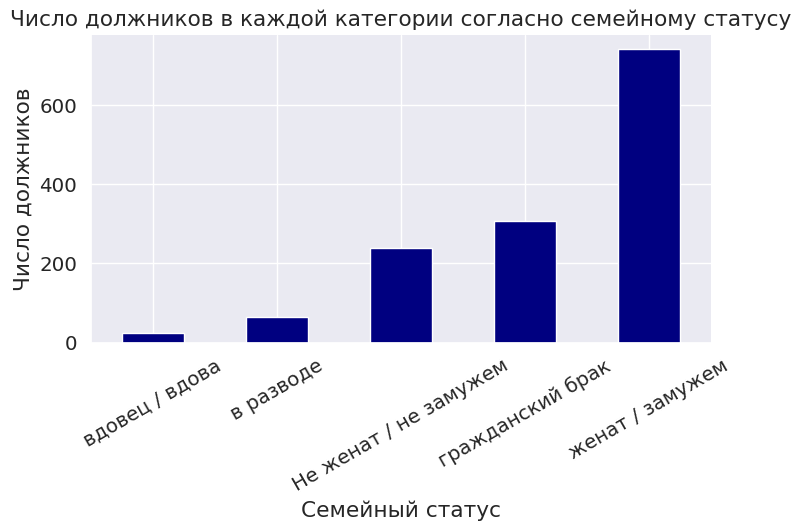

In [142]:
# Количество заёмщиков в соответствии с семейным статусом

table2.sort_values('debt_count', ascending = True)['debt'].plot(kind='bar',
                                                                figsize=(8, 4),
                                                                title='Число должников в каждой категории согласно семейному статусу',
                                                                color = 'navy')
plt.xticks(rotation=30)
plt.ylabel('Число должников')
plt.xlabel('Семейный статус')
plt.gca().spines[['top', 'right']].set_visible(False);

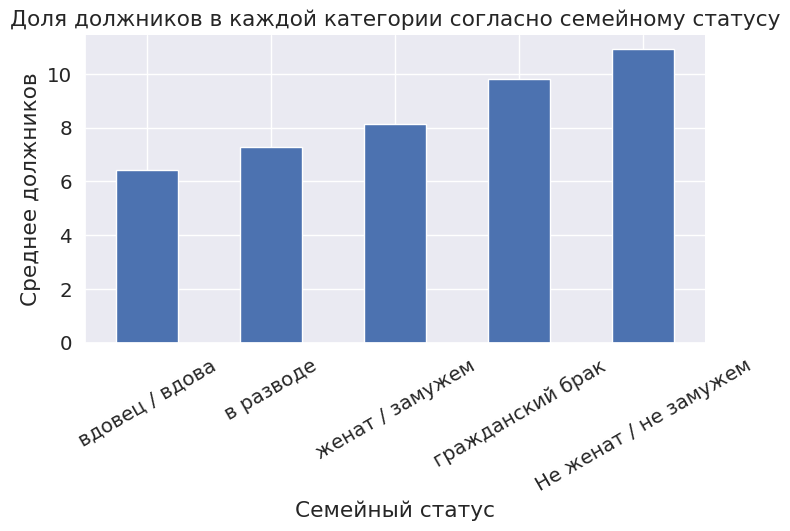

In [143]:
# Построим рафик зависимости доли неврзвративших в разрезе семейного статуса

table2.sort_values('debt_ratio', ascending = True)['debt_ratio'].plot(kind='bar',
                                                                      figsize=(8, 4),
                                                                      title='Доля должников в каждой категории согласно семейному статусу')
plt.xticks(rotation=30)
plt.ylabel('Среднее должников')
plt.xlabel('Семейный статус')
plt.gca().spines[['top', 'right']].set_visible(False);

>**Вывод:**  
>Индивиды из категорий 'вдовцы/вдовы' и 'в разводе' представляет незначительную долю в совкупности, хотя и имеют самый низкий процент невозвратов. Больше всего невозврата у неженатых/незамужних и находящихся в гражданском браке. Можно предположить, что это является следствие возраста заёмщиков, потому что такие категории как гражданский брак и Не женат / не замужем образуют самые молодые заёмщики среди остальных, склонных пероценивать свои возможности.

#### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Построим сводную таблицу показывающую зависимость между уровнем дохода и возвратом кредита в срок в соответствии со следующими категориями.

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [144]:
table3 = (data.groupby('total_income_category')['debt']
             .agg(['sum','count','mean'])
             .rename(columns={'sum': 'debt', 'count': 'debt_count', 'mean': 'debt_ratio'})
             .sort_values('debt_ratio'))
table3['debt_ratio'] = round(table3['debt_ratio']*100,2)
table3

debt  debt_count  debt_ratio
total_income_category                              
E                         0           7        0.00
B                       322        4431        7.27
D                        14         184        7.61
A                         2          25        8.00
C                      1038       11049        9.39

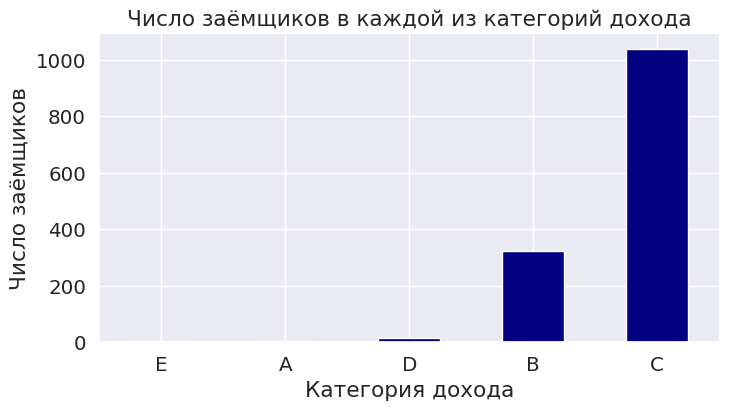

In [145]:
# Количество заёмщиков по категории дохода

table3.sort_values('debt_count', ascending = True)['debt'].plot(kind='bar',
                                                                figsize=(8, 4),
                                                                title='Число заёмщиков в каждой из категорий дохода',
                                                                color = 'navy')
plt.xticks(rotation=0)
plt.ylabel('Число заёмщиков')
plt.xlabel('Категория дохода')
plt.gca().spines[['top', 'right']].set_visible(False);

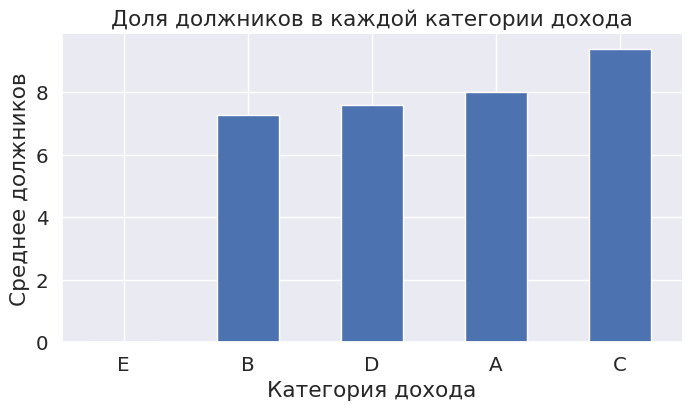

In [146]:
# Доли должников в каждой из категорий

table3.sort_values('debt_ratio', ascending = True)['debt_ratio'].plot(kind='bar',
                                                                      figsize=(8, 4),
                                                                      title='Доля должников в каждой категории дохода')
plt.xticks(rotation=0)
plt.ylabel('Среднее должников')
plt.xlabel('Категория дохода')
plt.gca().spines[['top', 'right']].set_visible(False);

>**Вывод:**  
>Самая многочисленная группа заёмщиков из категории **С** с доходом от 50000 до 200000. Эта же группа имеет самую высокую долю невозвратов кредита.

#### Как разные цели кредита влияют на его возврат в срок?

Построим сводную таблицу показывающую зависимость между целью кредита и возвратом кредита в срок в соответствии со следующими категориями:

- `операции с автомобилем`,
- `операции с недвижимостью`,
- `проведение свадьбы`,
- `получение образования`.

In [147]:
table4 = (data.groupby('purpose')['debt']
             .agg(['sum','count','mean'])
             .rename(columns={'sum': 'debt', 'count': 'debt_count', 'mean': 'debt_ratio'})
             .sort_values('debt_ratio'))
table4['debt_ratio'] = round(table4['debt_ratio']*100,2)
table4['age']=data.groupby('purpose')['dob_years'].mean().astype('int')
table4

debt  debt_count  debt_ratio  age
purpose                                                    
операции с недвижимостью   633        7951        7.96   39
проведение свадьбы         136        1704        7.98   39
получение образования      288        2906        9.91   39
операции с автомобилем     319        3135       10.18   40

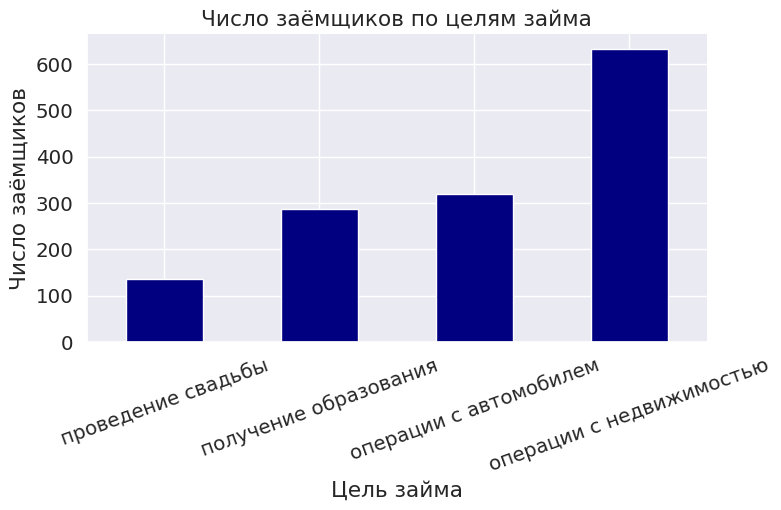

In [148]:
# Количество заёмщиков в соответствии с целями кредита

table4.sort_values('debt_count', ascending = True)['debt'].plot(kind='bar',
                                                                figsize=(8, 4),
                                                                title='Число заёмщиков по целям займа',
                                                                color = 'navy')
plt.xticks(rotation=20)
plt.ylabel('Число заёмщиков')
plt.xlabel('Цель займа')
plt.gca().spines[['top', 'right']].set_visible(False);

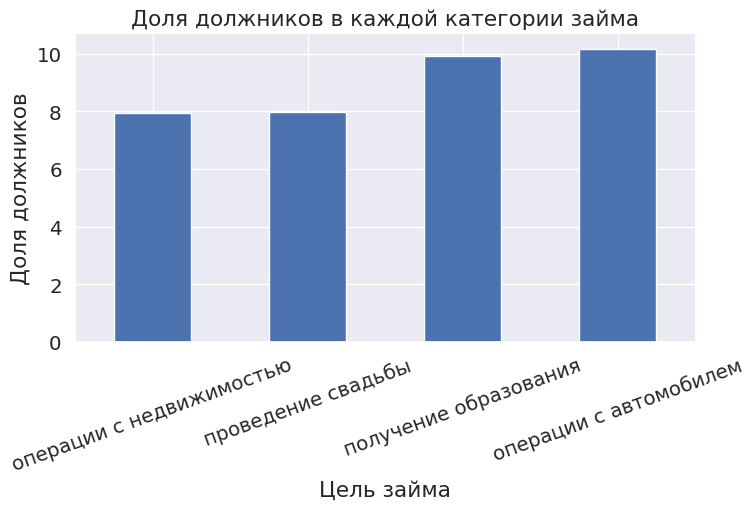

In [149]:
# Количество заёмщиков в соответствии с целями кредита

table4.sort_values('debt_ratio', ascending = True)['debt_ratio'].plot(kind='bar',
                                                                figsize=(8, 4),
                                                                title='Доля должников в каждой категории займа')
plt.xticks(rotation=20)
plt.ylabel('Доля должников')
plt.xlabel('Цель займа')
plt.gca().spines[['top', 'right']].set_visible(False);

>**Вывод:**  
>`проведение свадьбы` является категорией с самым низким уровнем невозврата кредита в срок. Самая высокая доля невозвратов у категорий `получение образования` и `операции с автомобилем`. Можно утверждать, что сделки с автомобилями являются самыми рискованными видом кредита. Самая многочисленная группа заёмщиков проводит операции с недвижимостью.

**Вывод**  
1. Есть ли зависимость между количеством детей и кредитоспособностью заёмщика?  
Анализ показал, что кредитоспособность заёмщиков с тремя детьми и бездетных выше остальных. Причём, кредитоспособность тех, кто имеет два ребёнка выше, чем тех у кого один.

2. Есть ли зависимость между семейным положением и возвратом кредита в срок?  
Анализ показала, что одинокие люди, которые имеют опыт брака легче возвращают долги, чем находящиеся в браке. Но при этом те, кто ещё не был в браке труднее расплачиваются с кредитами.

3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?  
Анализ показал, что заёмщики со средним уровнем дохода реже всех возвращают долги. На втором и третьем месте находятся клиенты с высоким и очень высоким уровнем дохода. Граждане, которые имеют доход ниже среднего легче возвращают долг.

4. Как разные цели кредита влияют на его возврат в срок?  
Операции с автомобилем и получение образования являются категориями с очень высоким уровнем невозврата долгов. Операции с недвижимостью  и проведение свадьбы - категрии, где самый низкий уровень невозврата.

## Ⅳ. Машинное обучение

In [150]:
# удалим лишние признаки

df = data.copy()
df = df.drop(['education', 'family_status', 'total_income_category'], axis = 1)
df.head()

children  days_employed  dob_years  education_id  family_status_id gender  \
0         1           8437         42             0                 0      F   
1         1           4024         36             1                 0      F   
2         0           5623         33             1                 0      M   
3         3           4124         32             1                 0      M   
5         0            926         27             0                 1      M   

  income_type   debt  total_income                   purpose  
0   сотрудник  False        253875  операции с недвижимостью  
1   сотрудник  False        112080    операции с автомобилем  
2   сотрудник  False        145885  операции с недвижимостью  
3   сотрудник  False        267628     получение образования  
5   компаньон  False        255763  операции с недвижимостью

In [151]:
# перекодируем категориальные признаки

num_features = ['gender', 'income_type', 'purpose']
df[num_features] = df[num_features].astype('category')
df[num_features] = df[num_features].apply(lambda x: x.cat.codes)

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15696 entries, 0 to 19191
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   children          15696 non-null  int64
 1   days_employed     15696 non-null  int64
 2   dob_years         15696 non-null  int64
 3   education_id      15696 non-null  int64
 4   family_status_id  15696 non-null  int64
 5   gender            15696 non-null  int8 
 6   income_type       15696 non-null  int8 
 7   debt              15696 non-null  bool 
 8   total_income      15696 non-null  int64
 9   purpose           15696 non-null  int8 
dtypes: bool(1), int64(6), int8(3)
memory usage: 1.4 MB


In [152]:
# Выявим первую 10-ку важных признаков

X = df.drop(['debt'], axis = 1)
y = df['debt']

bestFeatures = SelectKBest(score_func = chi2, k = 'all')
fit = bestFeatures.fit(X, y)
dfScores = pd.DataFrame(fit.scores_)
dfColumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfColumns, dfScores], axis = 1)
featureScores.columns = ['ПРИЗНАК:', 'ОЧКОВ ВАЖНОСТИ:']
print(featureScores.nlargest(10, 'ОЧКОВ ВАЖНОСТИ:'))

           ПРИЗНАК:  ОЧКОВ ВАЖНОСТИ:
7      total_income    521829.710686
1     days_employed    146481.275123
2         dob_years       130.109259
3      education_id        26.875750
5            gender        25.117566
4  family_status_id        22.618361
6       income_type         7.599127
0          children         3.915574
8           purpose         0.940938


In [153]:
X = df.drop(['debt'], axis = 1)
y = df['debt']

y.value_counts().reset_index()

debt  count
0  False  14320
1   True   1376

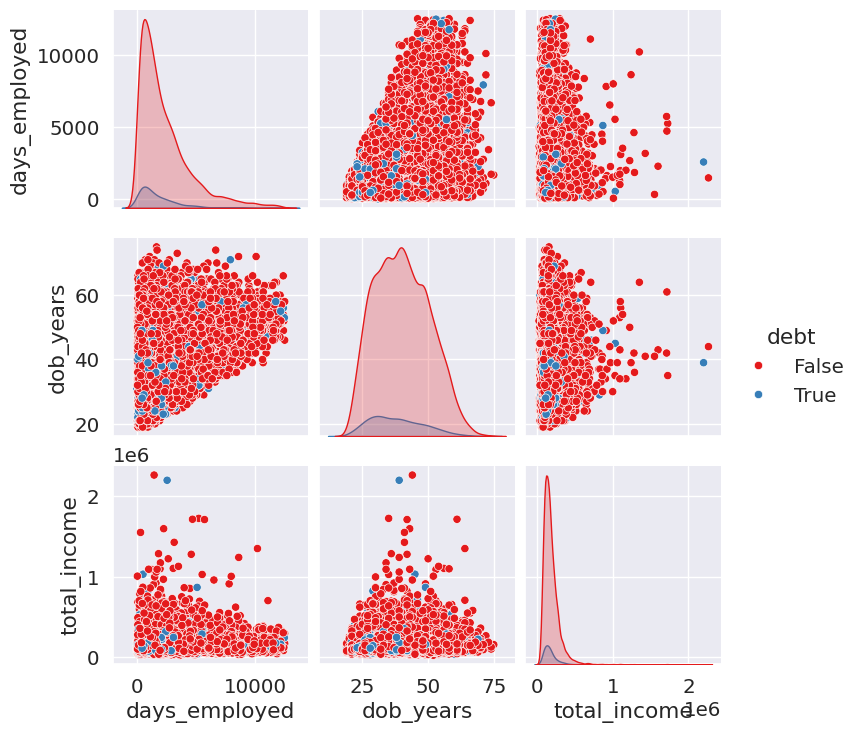

In [154]:
# Точечная диаграмма признаков по классам

sns.pairplot(df[['days_employed', 'dob_years', 'total_income', 'debt']], hue='debt', palette='Set1')
plt.show()

Наблюдается существенный дисбаланс классов без выраженной тенденции

In [155]:
# исправление дисбаланса классов c помощью oversampling

ros = RandomOverSampler(random_state=0)

X, y = ros.fit_resample(X, y)
y.value_counts()

debt
False    14320
True     14320
Name: count, dtype: int64

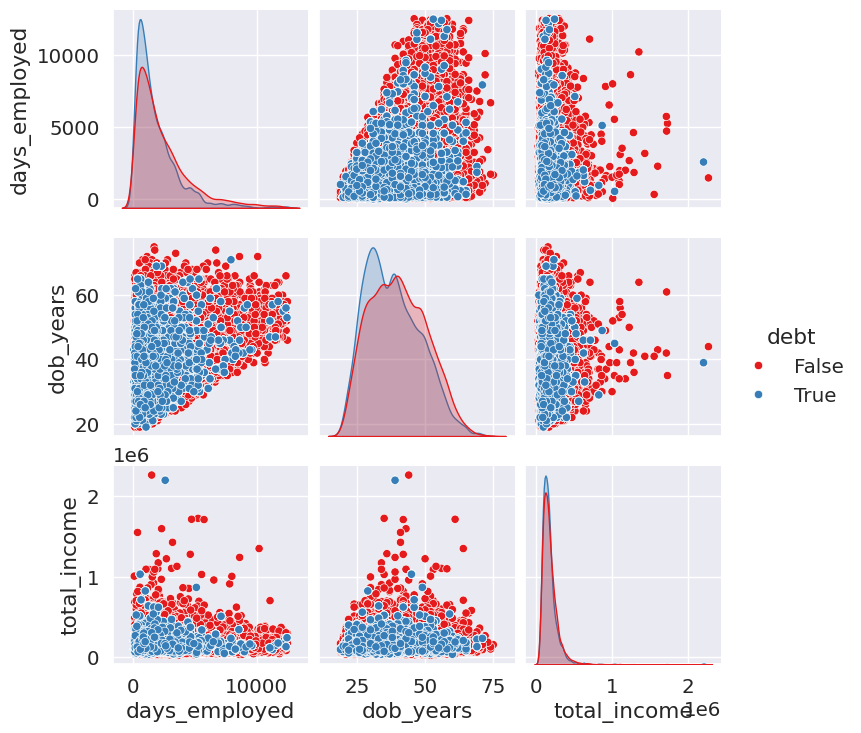

In [156]:
sns.pairplot(X.assign(debt = y)[['days_employed', 'dob_years', 'total_income', 'debt']], hue='debt', palette='Set1')
plt.show()

In [157]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [158]:
tr = tree.DecisionTreeClassifier(random_state=0)
tr.fit(x_train, y_train)

DecisionTreeClassifier(random_state=0)

In [159]:
# максимальная глубина дерева

print(f'Максимальная глубина дерева: {tr.tree_.max_depth}')

Максимальная глубина дерева: 30


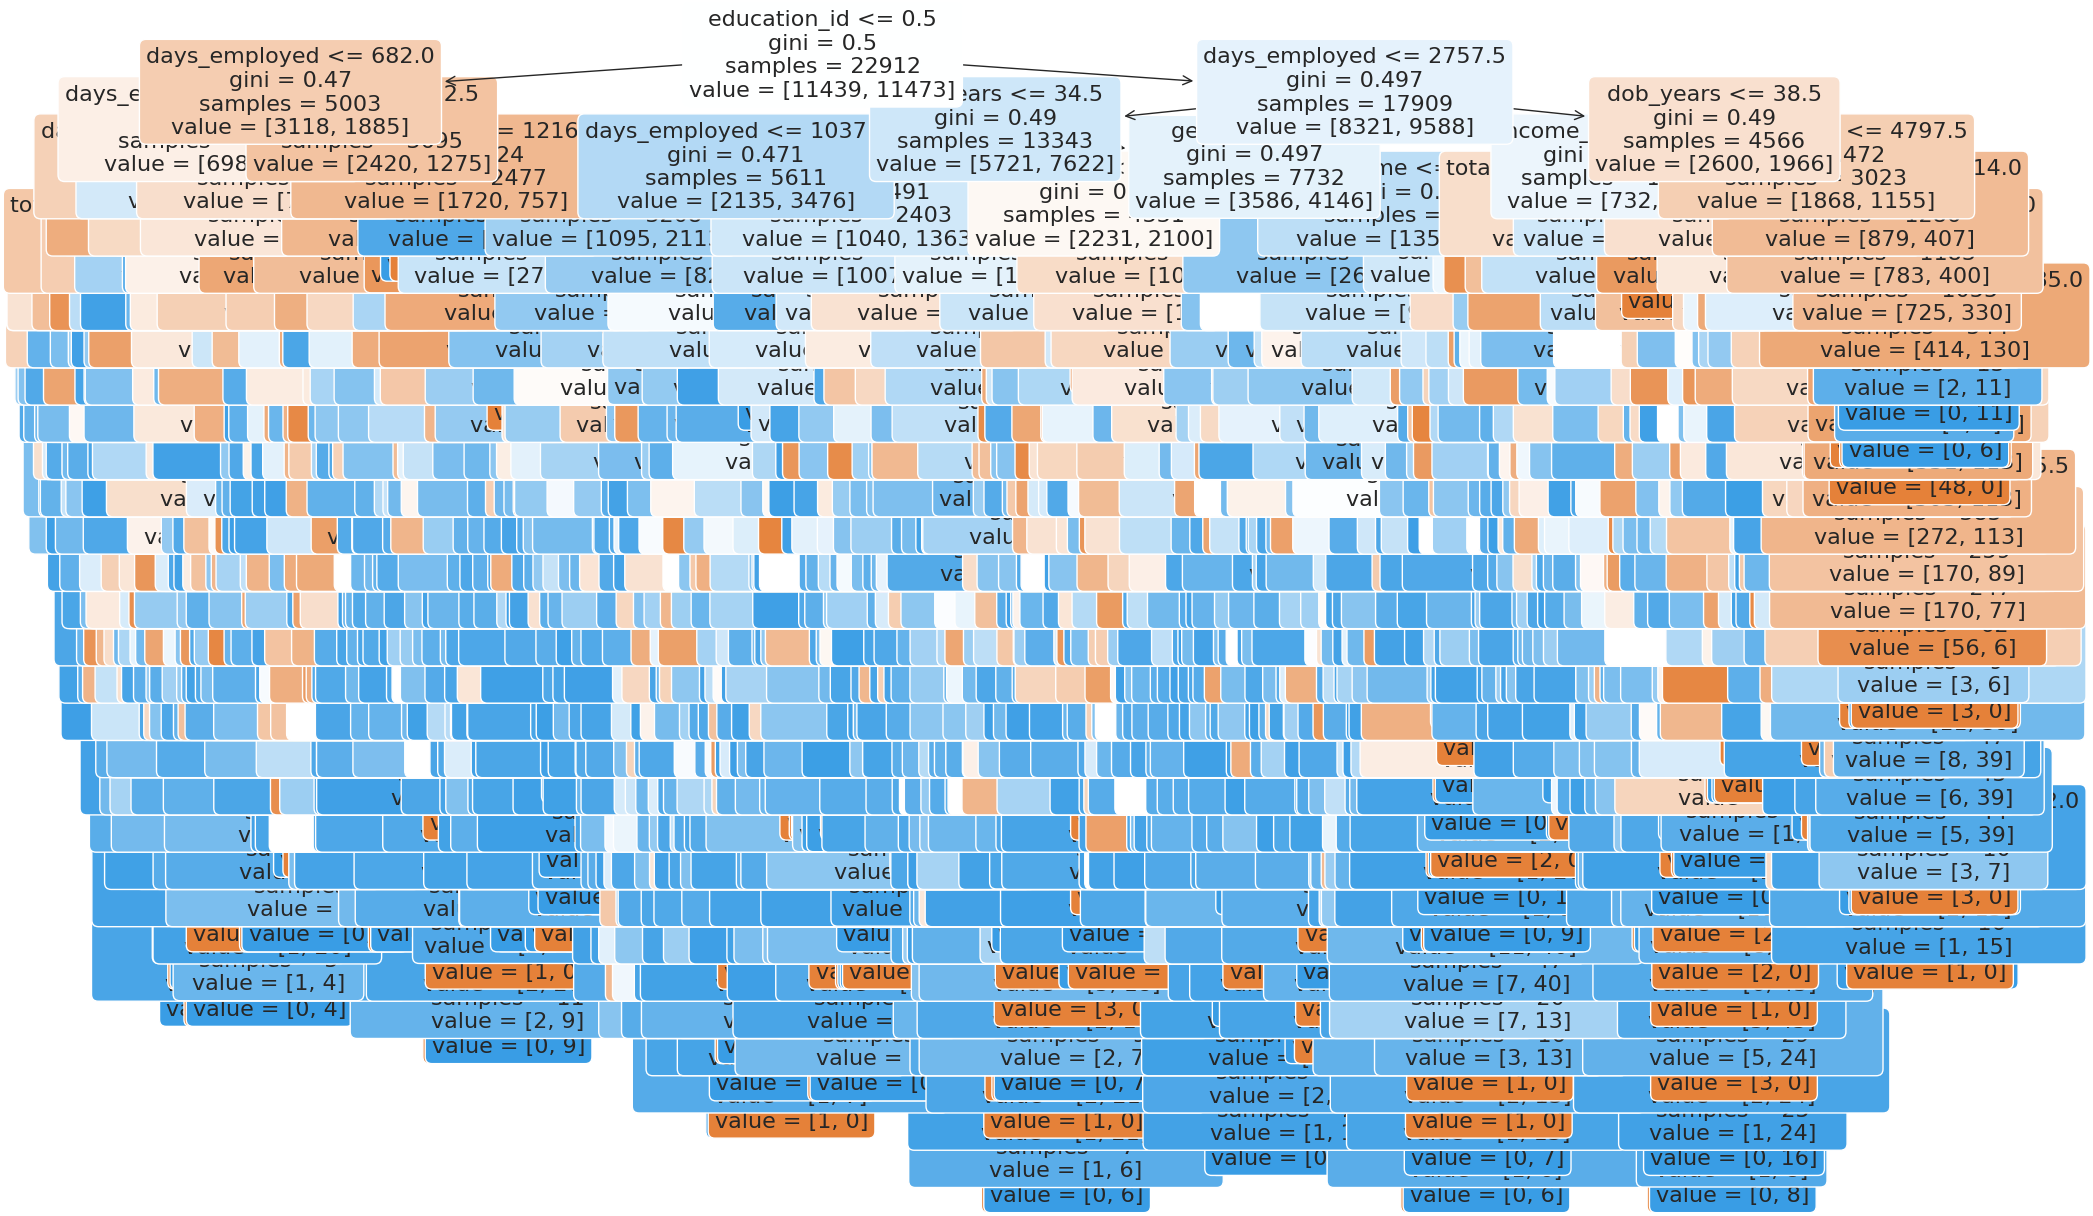

In [160]:
fig = plt.figure(figsize=(23,15))
tree.plot_tree(tr.fit(x_train, y_train), feature_names=X.columns, filled=True, rounded=True, fontsize=16);

In [161]:
tr_pred = tr.predict(x_test)
cv_tr = cross_val_score(tr, x_train, y_train, cv=10).mean()

In [162]:
print('Доля правильных ответов: %.3f' % tr.score(x_test, y_test))
print('Доля правильных ответов во время кросс-валидации: %0.3f' % cv_tr)
print('Точность результата измерений: %.3f' % precision_score(y_test, tr_pred))
print('Полнота: %.3f' % recall_score(y_test, tr_pred))
print('Оценка F1: %.3f' % f1_score(y_test, tr_pred))

Доля правильных ответов: 0.947
Доля правильных ответов во время кросс-валидации: 0.938
Точность результата измерений: 0.903
Полнота: 1.000
Оценка F1: 0.949


In [163]:
tr_probs = tr.predict_proba(x_test)
tr_probs = tr_probs[:, 1]
auc_tr = roc_auc_score(y_test, tr_probs)
print('AUC: %.2f' % auc_tr)

AUC: 0.95


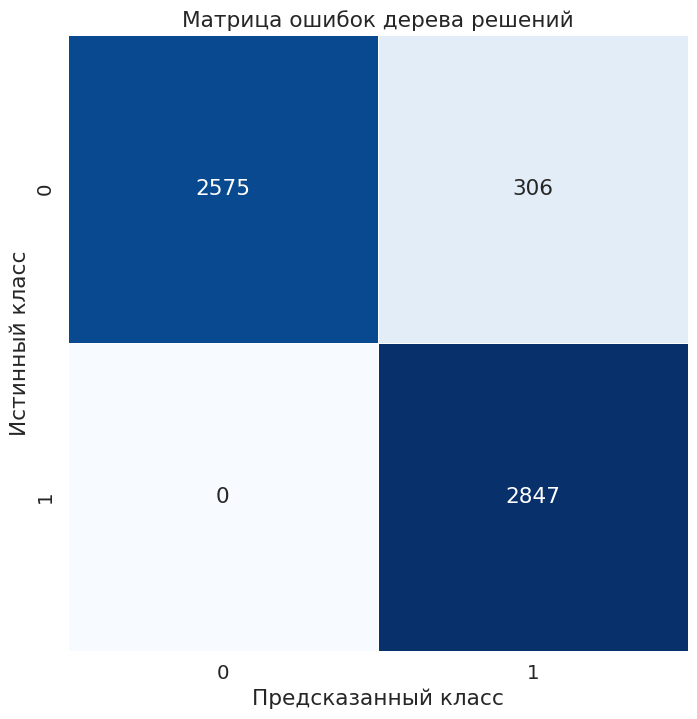

In [164]:
tr_matrix = confusion_matrix(y_test,tr_pred)
sns.set(font_scale=1.3)
plt.subplots(figsize=(8,8))
sns.heatmap(tr_matrix, annot=True, cbar=False, cmap='Blues', linewidth=0.5, fmt="d")
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.title('Матрица ошибок дерева решений');

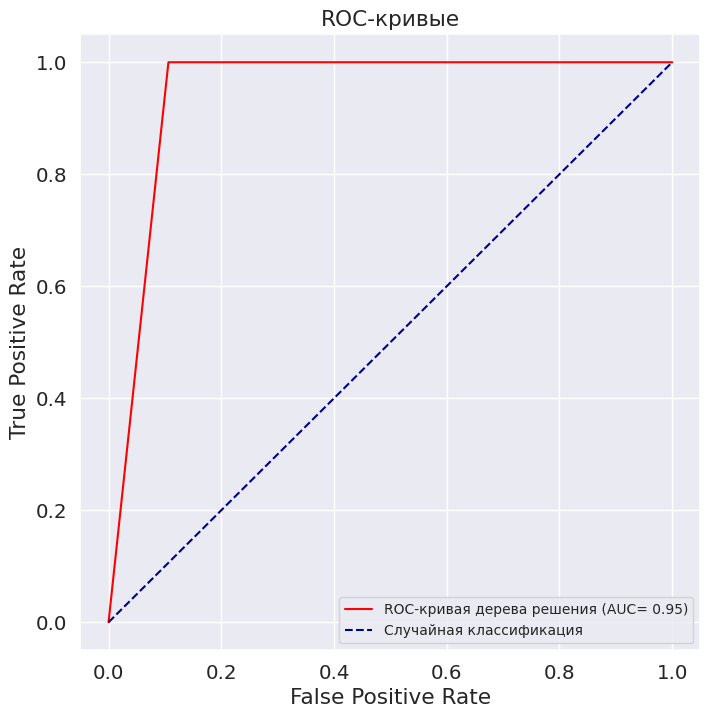

In [165]:
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_test, tr_probs)

plt.figure(figsize=(8,8))
plt.plot(tr_fpr, tr_tpr, color='red', label='ROC-кривая дерева решения (AUC= %0.2f)'% auc_tr)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Случайная классификация')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.legend(loc='lower right', prop={'size': 10})
plt.show();

## Ⅴ. Общий вывод.

Предоставленные данные были получены в текстовом формате и требовали предварительной обработки для дальнейшего анализа. В ходе исследовательского анализа данных были предприняты следующие действия:  
- Обнаружены и удалены явные и неявные дубликаты  
- Удалены пропуски  
- Изменены типы некоторых признаков  
- Исправленв отрицательные значения  
- Удалены выбросы  
- Сделана категоризация некоторых признаков  

Анализ показал, что люди со средним образованием чаще берут кредиты, далее идут клиенты с высшим образованием. Клиенты с неоконченным высшим, начальным образованием, а также с учёной степенью реже берут кредит.  
Находящиеся в браке чаще берут займ. Неженатые и находящиеся в гражданском браке меньше обращаются за кредитом. Намного реже берут кредиты те, кто в разводе или одинокие.  
Женщины чаще берут кредиты.  
Сотрудники и компаньоны чаще обращаются за кредитом, чем пенсионеры. Госслужащие реже всех обращаются в банки.  
Самая популярная цель займа - операции с недвижимостью. На втором и третьем местах по популярности - операции с автомобилями и получение образования, на последнем месте - проведение свадьбы.  
За кредитом чаще обращаются клиенты не имеющие детей. Далее по количеству обращений находятся клиенты имеющие по одному, два и три ребёнка соответственно.  
Средний возраст заёмщика - 39 лет.  
8% заёмщиков имели проблемы с возвратом кредита.  
Кредиты чаще берут граждане с доходом от 50 000 до 200 000 тыс, что является средними доходами. На втором месте по обращению за кредитами люди с доходом выше среднего.  
С увеличением трудового стажа заёмщик реже обращается за кредитом.  Чаще берут кредиты клиенты с трудовым стажем до 10 лет.

**Ответы на целевые вопросы анализа.**  
Кредитоспособность заёмщиков с тремя детьми и бездетных выше остальных. Причём, кредитоспособность тех, кто имеет два ребёнка выше, чем тех у кого один.  
Одинокие люди, которые имеют опыт брака легче возвращают долги, чем находящиеся в браке. Но при этом те, кто ещё не был в браке труднее расплачиваются с кредитами.  
Заёмщики со средним уровнем дохода реже всех возвращают долги. На втором и третьем месте находятся клиенты с высоким и очень высоким уровнем дохода. Граждане, которые имеют доход ниже среднего легче возвращают долг.  
Операции с автомобилем и получение образования являются категориями с очень высоким уровнем невозврата долгов. Операции с недвижимостью и проведение свадьбы - категрии, где самый низкий уровень невозврата.  

В ходе машинного обучения был исправлен дисбалан целевой переменной с помощью RandomOverSampler().  
Выяснилось, что такие признаки, как уровень дохода, стаж, возраст являются основополагающими при принятии решения о выдачи кредита.  
Для обучения модели мы использовали обучающее дерево как один из эффективных алгоритмов бинарной классификации.  
Были использованы следующие метрики для оценки модели:  
- accuracy
- precision
- recall
- f1  
- confusion matrix  

**AUC - 0.95**